In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression # untuk  pemodelan dengan logistic regression
from sklearn.neighbors import KNeighborsClassifier # untuk pemodelan dengan K Neighbors Classifier 
from sklearn.ensemble import RandomForestClassifier # untuk pemodelan dengan Random Forest Classifier
from sklearn.tree import DecisionTreeClassifier # untuk pemodelan dengan Decision Tree Classifier
from sklearn.svm import SVC # untuk pemodelan dengan Support Vector Machine dengan tipe Classification
from xgboost import XGBClassifier # untuk pemodelan dengan XGBoost (Extreme Gradient Boosting) untuk tipe Classification
from sklearn.ensemble import  AdaBoostClassifier # untuk pemodelan dengan Adaptive Boosting untuk tipe Classification

from sklearn.model_selection import train_test_split # untuk spliting dataset menjadi train dan test sebagai bagian pemodelan
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score # untuk analisis akurasi, F1, recall, dan precision jika analisis dengan classification report mengalami masalah
from sklearn.metrics import classification_report, confusion_matrix # mengimport package tentang classification report dan confusion matrix
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc # ROC : receiver operating characteristic; AUC = Area under curve; Hindari AUC bernilai 0.5 ke bawah; 0.7 sudah bagus
import statsmodels.api as sm # mengimport package tentang statsmodels untuk analisa sebuah model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler, StandardScaler # mengimport package tentang scaling sebagai bagian dari feature engineering

from sklearn.model_selection import GridSearchCV # mengimport package tentang GridSearchCV untuk hyper parameter tuning dan cross validation (CV)

# untuk mempermudah pemodelan dengan data yang berkategori numerical dan categorical, pipeline dapat digunakan.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


# Jika data bersifat imbalanced, beberapa package berikut dapat diimport untuk meng-handle imbalanced data
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Untuk mengekspor dataset ke dashboard
import pickle
import joblib

%matplotlib inline

pd.options.display.max_columns = 999 # biar koloom tidak ada titik2, ditampilkan semua
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format='{:,}'.format

In [2]:
df = pd.read_csv("C:/Users/ASUS/visual_studio_code/final_project/dataset/bank-additional-full_clean.csv", index_col =0)
df.head()

,duration,pdays,previous,poutcome,emp.var.rate,euribor3m,nr.employed,y
0,261,999,0,nonexistent,1.1,4.857,"5,191.0",no
1,149,999,0,nonexistent,1.1,4.857,"5,191.0",no
2,226,999,0,nonexistent,1.1,4.857,"5,191.0",no
3,151,999,0,nonexistent,1.1,4.857,"5,191.0",no
4,307,999,0,nonexistent,1.1,4.857,"5,191.0",no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   duration      41188 non-null  int64  
 1   pdays         41188 non-null  int64  
 2   previous      41188 non-null  int64  
 3   poutcome      41188 non-null  object 
 4   emp.var.rate  41188 non-null  float64
 5   euribor3m     41188 non-null  float64
 6   nr.employed   41188 non-null  float64
 7   y             41188 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 2.8+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,"41,188.0",258.2850101971448,259.2792488364648,0.0,102.0,180.0,319.0,"4,918.0"
pdays,"41,188.0",962.4754540157328,186.9109073447418,0.0,999.0,999.0,999.0,999.0
previous,"41,188.0",0.17296299893172767,0.4949010798392897,0.0,0.0,0.0,0.0,7.0
emp.var.rate,"41,188.0",0.08188550063125165,1.5709597405170255,-3.4,-1.8,1.1,1.4,1.4
euribor3m,"41,188.0",3.621290812858114,1.734447404851267,0.634,1.344,4.857,4.961,5.045
nr.employed,"41,188.0","5,167.035910944936",72.25152766826108,"4,963.6","5,099.1","5,191.0","5,228.1","5,228.1"


In [5]:
df.describe(include='O').T # descripe data object

,count,unique,top,freq
poutcome,41188,3,nonexistent,35563
y,41188,2,no,36548


In [6]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

### Data termasuk Imbalanced Data karena y bernilai no adalah 36548 (88.73 % dari keseluruhan y) sedangkan y bernilai yes adalah 4640 (11.27 % dari keseluruhan y). Namun, Imbalanced Data belum bertipe ekstrem, misal 99 % : 1 %. Maka, pemodelan data akan dibuat dengan kondisi jika Imbalanced Data di-handle atau tidak di-handle.

### Untuk menghitung nilai ROC dan AUC, dibuat df_dummy karena query-nya hanya bisa mendeteksi nilai angka

In [7]:
df_dummy = df.copy()
df_dummy.head()

,duration,pdays,previous,poutcome,emp.var.rate,euribor3m,nr.employed,y
0,261,999,0,nonexistent,1.1,4.857,"5,191.0",no
1,149,999,0,nonexistent,1.1,4.857,"5,191.0",no
2,226,999,0,nonexistent,1.1,4.857,"5,191.0",no
3,151,999,0,nonexistent,1.1,4.857,"5,191.0",no
4,307,999,0,nonexistent,1.1,4.857,"5,191.0",no


In [8]:
df_dummy = pd.get_dummies(data=df_dummy, columns=['poutcome'])

In [9]:
df_dummy['y'] = df_dummy['y'].map({'no' : 0, 'yes' : 1})

In [10]:
df_dummy.head()

,duration,pdays,previous,emp.var.rate,euribor3m,nr.employed,y,poutcome_failure,poutcome_nonexistent,poutcome_success
0,261,999,0,1.1,4.857,"5,191.0",0,0,1,0
1,149,999,0,1.1,4.857,"5,191.0",0,0,1,0
2,226,999,0,1.1,4.857,"5,191.0",0,0,1,0
3,151,999,0,1.1,4.857,"5,191.0",0,0,1,0
4,307,999,0,1.1,4.857,"5,191.0",0,0,1,0


# Data Splitting

In [11]:
X = df.drop(columns='y')
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .2, random_state=42)

In [12]:
X_train.columns

Index(['duration', 'pdays', 'previous', 'poutcome', 'emp.var.rate',
       'euribor3m', 'nr.employed'],
      dtype='object')

In [13]:
X_dummy = df_dummy.drop(columns='y')
y_dummy = df_dummy.y

X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy, y_dummy, stratify = y_dummy, test_size = .2, random_state=42)

In [14]:
X_train_dummy.columns

Index(['duration', 'pdays', 'previous', 'emp.var.rate', 'euribor3m',
       'nr.employed', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success'],
      dtype='object')

# Modelling

## K Neighbors Classifier

In [15]:
X_dummy = df_dummy.drop(columns='y')
y_dummy = df_dummy.y

X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy, y_dummy, stratify = y_dummy, test_size = .2, random_state=42)

In [15]:
scaler_robust = RobustScaler()

X_train_robustscaled = scaler_robust.fit_transform(X_train_dummy)

X_test_robustscaled = scaler_robust.fit_transform(X_test_dummy)

model_dummyKNN = KNeighborsClassifier()

params_dummyKNN = {
    "n_neighbors" : range(1,50,2),
    "weights" : ["uniform", "distance"],
    "p" : [2, 1]
}

model_dummyKNN = GridSearchCV(model_dummyKNN, params_dummyKNN, cv=3, n_jobs=-1, verbose=1)

model_dummyKNN.fit(X_train_robustscaled, y_train_dummy)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 50, 2), 'p': [2, 1],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [17]:
y_pred_dummyKNN_robust = model_dummyKNN.predict(X_test_robustscaled)

print(classification_report(y_test_dummy, y_pred_dummyKNN_robust))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.67      0.51      0.58       928

    accuracy                           0.92      8238
   macro avg       0.81      0.74      0.77      8238
weighted avg       0.91      0.92      0.91      8238



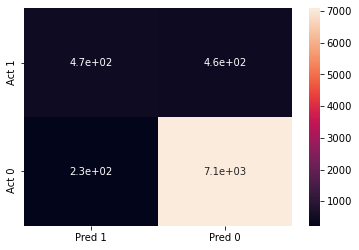

In [18]:
cm_KNNrobust = confusion_matrix(y_test_dummy, y_pred_dummyKNN_robust, labels=[1, 0]) 
df_cm_KNNrobust = pd.DataFrame(cm_KNNrobust, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_KNNrobust, annot=True)

In [19]:
roc_auc_score(y_test_dummy, y_pred_dummyKNN_robust)

0.7371672897306476

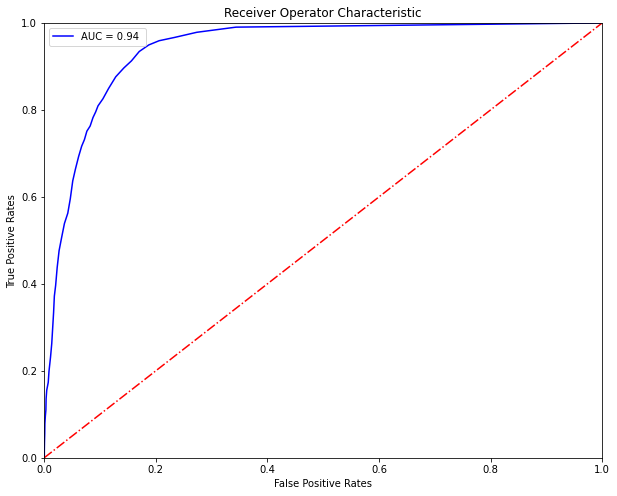

In [20]:
probs = model_dummyKNN.predict_proba(X_test_robustscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [21]:
model_dummyKNN.best_params_

{'n_neighbors': 49, 'p': 1, 'weights': 'uniform'}

In [22]:
model_dummyKNN.best_score_

0.9104703450743372

In [24]:
scaler_minmax = MinMaxScaler()

X_train_minmaxscaled = scaler_minmax.fit_transform(X_train_dummy)

X_test_minmaxscaled = scaler_minmax.fit_transform(X_test_dummy)

model_dummyKNN2 = KNeighborsClassifier()

params_dummyKNN = {
    "n_neighbors" : range(1,50,2),
    "weights" : ["uniform", "distance"],
    "p" : [2, 1]
}

model_dummyKNN2 = GridSearchCV(model_dummyKNN2, params_dummyKNN, cv=3, n_jobs=-1, verbose=1)

model_dummyKNN2.fit(X_train_minmaxscaled, y_train_dummy)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 50, 2), 'p': [2, 1],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [25]:
y_pred_dummyKNN_minmax = model_dummyKNN2.predict(X_test_minmaxscaled)

print(classification_report(y_test_dummy, y_pred_dummyKNN_minmax))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7310
           1       0.58      0.67      0.62       928

    accuracy                           0.91      8238
   macro avg       0.77      0.80      0.78      8238
weighted avg       0.91      0.91      0.91      8238



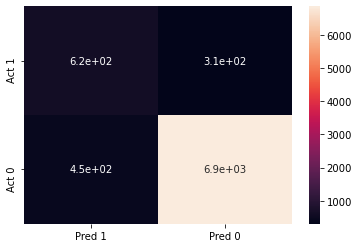

In [26]:
cm_KNNminmax = confusion_matrix(y_test_dummy, y_pred_dummyKNN_minmax, labels=[1, 0]) 
df_cm_KNNminmax = pd.DataFrame(cm_KNNminmax, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_KNNminmax, annot=True)

In [27]:
roc_auc_score(y_test_dummy, y_pred_dummyKNN_minmax)

0.8036055651209962

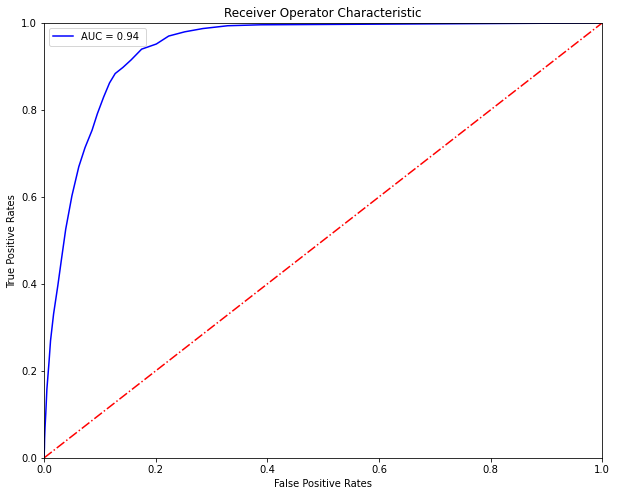

In [28]:
probs = model_dummyKNN2.predict_proba(X_test_minmaxscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [29]:
model_dummyKNN2.best_params_

{'n_neighbors': 31, 'p': 1, 'weights': 'uniform'}

In [30]:
model_dummyKNN2.best_score_

0.9101971956616084

In [31]:
scaler_standard = StandardScaler()

X_train_standardscaled = scaler_standard.fit_transform(X_train_dummy)

X_test_standardscaled = scaler_standard.fit_transform(X_test_dummy)

model_dummyKNN3 = KNeighborsClassifier()

params_dummyKNN = {
    "n_neighbors" : range(1,50,2),
    "weights" : ["uniform", "distance"],
    "p" : [2, 1]
}

model_dummyKNN3 = GridSearchCV(model_dummyKNN3, params_dummyKNN, cv=3, n_jobs=-1, verbose=1)

model_dummyKNN3.fit(X_train_standardscaled, y_train_dummy)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 50, 2), 'p': [2, 1],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [32]:
y_pred_dummyKNN_standard = model_dummyKNN3.predict(X_test_standardscaled)

print(classification_report(y_test_dummy, y_pred_dummyKNN_standard))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.67      0.51      0.58       928

    accuracy                           0.92      8238
   macro avg       0.80      0.74      0.76      8238
weighted avg       0.91      0.92      0.91      8238



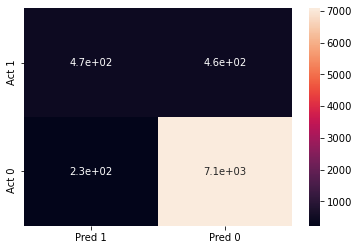

In [33]:
cm_KNNstandard = confusion_matrix(y_test_dummy, y_pred_dummyKNN_standard, labels=[1, 0]) 
df_cm_KNNstandard = pd.DataFrame(cm_KNNstandard, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_KNNstandard, annot=True)

In [34]:
roc_auc_score(y_test_dummy, y_pred_dummyKNN_standard)

0.7368936919194301

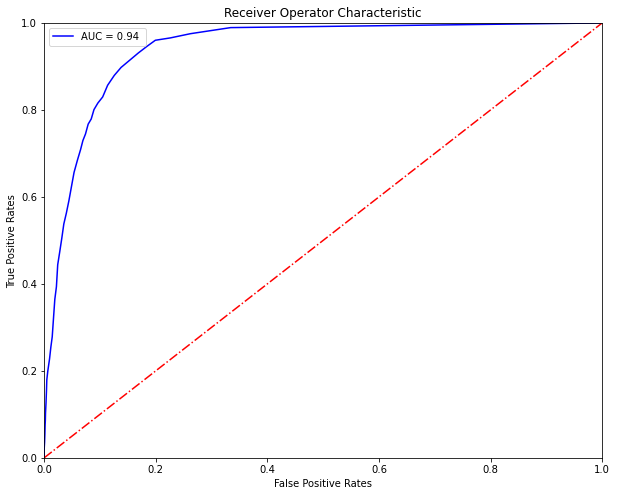

In [35]:
probs = model_dummyKNN3.predict_proba(X_test_standardscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [36]:
model_dummyKNN3.best_params_

{'n_neighbors': 49, 'p': 2, 'weights': 'uniform'}

In [37]:
model_dummyKNN3.best_score_

0.9108042136982895

## Decision Tree Clasifier

In [16]:
scaler_robust = RobustScaler()

X_train_robustscaled = scaler_robust.fit_transform(X_train_dummy)

X_test_robustscaled = scaler_robust.fit_transform(X_test_dummy)

In [42]:
model_dummyDT = DecisionTreeClassifier()

params_dummyDT = {
    "max_depth" : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],    
    "min_samples_split" : range(2,30,1),
    "min_samples_leaf" : range(1,15,1),
    "max_features" : ["auto", 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

model_dummyDT = GridSearchCV(model_dummyDT, params_dummyDT, cv=3, n_jobs=-1, verbose=1)

model_dummyDT.fit(X_train_robustscaled, y_train_dummy)

Fitting 3 folds for each of 47432 candidates, totalling 142296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 2936 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 4736 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 6936 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 9536 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12536 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 18696 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 26296 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 34696 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 43896 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 53896 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 64696 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 76296 tas

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                          0.7, 0.8, 0.9, 1],
                         'min_samples_leaf': range(1, 15),
                         'min_samples_split': range(2, 30)},
             verbose=1)

In [43]:
y_pred_dummy_DTrobust = model_dummyDT.predict(X_test_robustscaled)

print(classification_report(y_test_dummy, y_pred_dummy_DTrobust))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.67      0.50      0.57       928

    accuracy                           0.92      8238
   macro avg       0.80      0.73      0.76      8238
weighted avg       0.91      0.92      0.91      8238



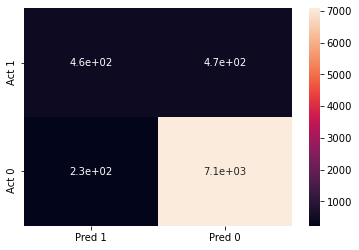

In [44]:
cm_DTrobust = confusion_matrix(y_test_dummy, y_pred_dummy_DTrobust, labels=[1, 0]) 
df_cm_DTrobust = pd.DataFrame(cm_DTrobust, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_DTrobust, annot=True)

In [45]:
roc_auc_score(y_test_dummy, y_pred_dummy_DTrobust)

0.7321129534412001

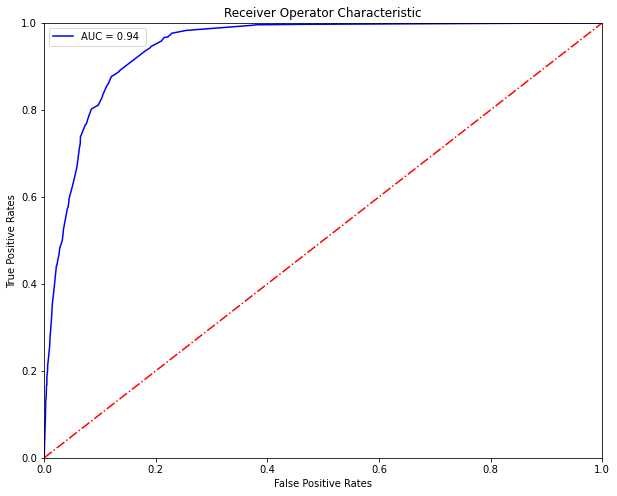

In [46]:
probs = model_dummyDT.predict_proba(X_test_robustscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [47]:
model_dummyDT.best_params_

{'max_depth': 7,
 'max_features': 0.8,
 'min_samples_leaf': 7,
 'min_samples_split': 7}

In [48]:
model_dummyDT.best_score_

0.9136569251997012

In [49]:
scaler_minmax = MinMaxScaler()

X_train_minmaxscaled = scaler_minmax.fit_transform(X_train_dummy)

X_test_minmaxscaled = scaler_minmax.fit_transform(X_test_dummy)

model_dummyDT2 = DecisionTreeClassifier()

params_dummyDT = {
    "max_depth" : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],    
    "min_samples_split" : range(2,30,1),
    "min_samples_leaf" : range(1,15,1),
    "max_features" : ["auto", 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

model_dummyDT2 = GridSearchCV(model_dummyDT2, params_dummyDT, cv=3, n_jobs=-1, verbose=1)

model_dummyDT2.fit(X_train_minmaxscaled, y_train_dummy)

Fitting 3 folds for each of 47432 candidates, totalling 142296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 4760 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 6960 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 9560 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12560 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 18848 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 26448 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 34848 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 44048 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 54048 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 64848 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 76448 tas

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                          0.7, 0.8, 0.9, 1],
                         'min_samples_leaf': range(1, 15),
                         'min_samples_split': range(2, 30)},
             verbose=1)

In [51]:
y_pred_dummy_DTminmax = model_dummyDT2.predict(X_test_minmaxscaled)

print(classification_report(y_test_dummy, y_pred_dummy_DTminmax))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      7310
           1       0.56      0.77      0.65       928

    accuracy                           0.91      8238
   macro avg       0.76      0.85      0.80      8238
weighted avg       0.92      0.91      0.91      8238



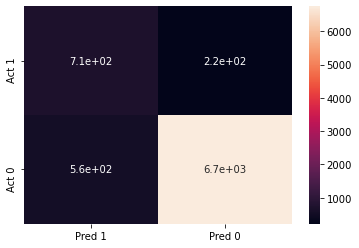

In [52]:
cm_DTminmax = confusion_matrix(y_test_dummy, y_pred_dummy_DTminmax, labels=[1, 0]) 
df_cm_DTminmax = pd.DataFrame(cm_DTminmax, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_DTminmax, annot=True)

In [53]:
roc_auc_score(y_test_dummy, y_pred_dummy_DTminmax)

0.8457873897353648

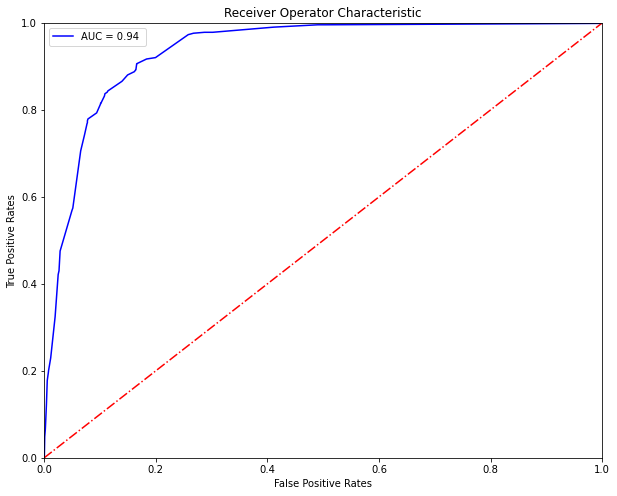

In [54]:
probs = model_dummyDT2.predict_proba(X_test_minmaxscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [55]:
model_dummyDT2.best_params_

{'max_depth': 6,
 'max_features': 0.8,
 'min_samples_leaf': 4,
 'min_samples_split': 28}

In [56]:
model_dummyDT2.best_score_

0.9132624009159181

In [57]:
scaler_standard = StandardScaler()

X_train_standardscaled = scaler_standard.fit_transform(X_train_dummy)

X_test_standardscaled = scaler_standard.fit_transform(X_test_dummy)

model_dummyDT3 = DecisionTreeClassifier()

params_dummyDT = {
    "max_depth" : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],    
    "min_samples_split" : range(2,30,1),
    "min_samples_leaf" : range(1,15,1),
    "max_features" : ["auto", 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

model_dummyDT3 = GridSearchCV(model_dummyDT3, params_dummyDT, cv=3, n_jobs=-1, verbose=1)

model_dummyDT3.fit(X_train_standardscaled, y_train_dummy)

Fitting 3 folds for each of 47432 candidates, totalling 142296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 4760 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 6960 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 9560 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 12560 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 18848 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 26448 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 34848 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 44048 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 54048 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 64848 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 76448 tas

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                          0.7, 0.8, 0.9, 1],
                         'min_samples_leaf': range(1, 15),
                         'min_samples_split': range(2, 30)},
             verbose=1)

In [58]:
y_pred_dummy_DTstandard = model_dummyDT3.predict(X_test_standardscaled)

print(classification_report(y_test_dummy, y_pred_dummy_DTstandard))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7310
           1       0.65      0.53      0.58       928

    accuracy                           0.91      8238
   macro avg       0.79      0.75      0.77      8238
weighted avg       0.91      0.91      0.91      8238



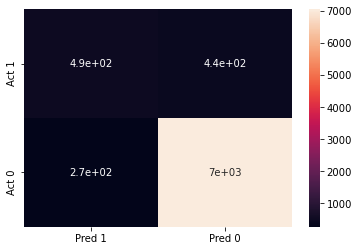

In [59]:
cm_DTstandard = confusion_matrix(y_test_dummy, y_pred_dummy_DTstandard, labels=[1, 0]) 
df_cm_DTstandard = pd.DataFrame(cm_DTstandard, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_DTstandard, annot=True)

In [60]:
roc_auc_score(y_test_dummy, y_pred_dummy_DTstandard)

0.747157147742818

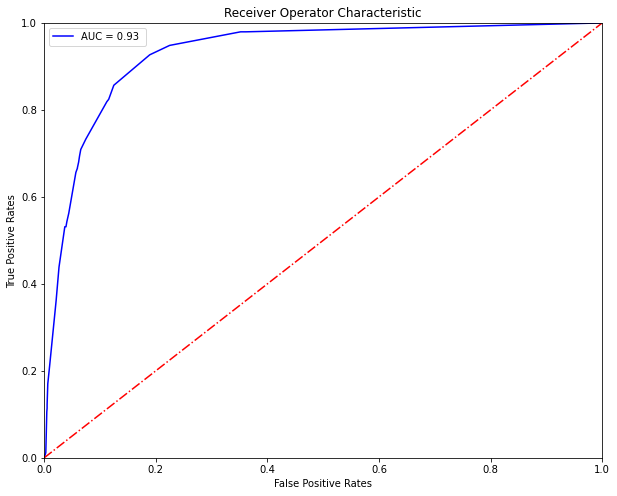

In [61]:
probs = model_dummyDT3.predict_proba(X_test_standardscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [62]:
model_dummyDT3.best_params_

{'max_depth': 5,
 'max_features': 0.7,
 'min_samples_leaf': 4,
 'min_samples_split': 28}

In [63]:
model_dummyDT3.best_score_

0.913080353806409

## Random Forest Classifier

In [14]:
scaler_robust = RobustScaler()

X_train_robustscaled = scaler_robust.fit_transform(X_train_dummy)

X_test_robustscaled = scaler_robust.fit_transform(X_test_dummy)

model_dummyRF = RandomForestClassifier()

params_dummyRF = {
    "n_estimators" : [100, 400, 700, 1000],  
    "max_depth" : [None, 2, 4, 6, 8, 10],
    "min_samples_split" : [2,6,10],
    "min_samples_leaf" : [1,3,5],
    "max_features" : ["auto", 0.25, 0.5, 0.75, 1]
}

model_dummyRF = GridSearchCV(model_dummyRF, params_dummyRF, cv=3, n_jobs=-1, verbose=1)

model_dummyRF.fit(X_train_robustscaled, y_train_dummy)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 58.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 118.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 144.3min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 145.8min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10],
                         'max_features': ['auto', 0.25, 0.5, 0.75, 1],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [100, 400, 700, 1000]},
             verbose=1)

In [39]:
y_pred_dummyRFrobust = model_dummyRF.predict(X_test_robustscaled)

print(classification_report(y_test_dummy, y_pred_dummyRFrobust))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7310
           1       0.70      0.55      0.61       928

    accuracy                           0.92      8238
   macro avg       0.82      0.76      0.78      8238
weighted avg       0.92      0.92      0.92      8238



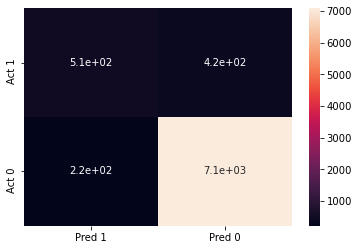

In [40]:
cm_RFrobust = confusion_matrix(y_test_dummy, y_pred_dummyRFrobust, labels=[1, 0]) 
df_cm_RFrobust = pd.DataFrame(cm_RFrobust, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_RFrobust, annot=True)

In [41]:
roc_auc_score(y_test_dummy, y_pred_dummyRFrobust)

0.7574446318222557

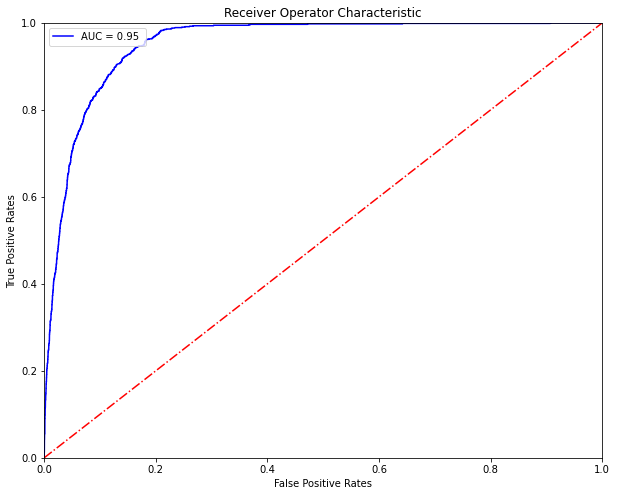

In [19]:
probs = model_dummyRF.predict_proba(X_test_robustscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [64]:
model_dummyRF.best_params_

{'max_depth': 8,
 'max_features': 0.75,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 400}

In [65]:
model_dummyRF.best_score_

0.9140211713894414

In [23]:
scaler_minmax = MinMaxScaler()

X_train_minmaxscaled = scaler_minmax.fit_transform(X_train_dummy)

X_test_minmaxscaled = scaler_minmax.fit_transform(X_test_dummy)

model_dummyRF2 = RandomForestClassifier()

params_dummyRF = {
    "n_estimators" : [100, 400, 700, 1000],  
    "max_depth" : [None, 2, 4, 6, 8, 10],
    "min_samples_split" : [2,6,10],
    "min_samples_leaf" : [1,3,5],
    "max_features" : ["auto", 0.25, 0.5, 0.75, 1]
}

model_dummyRF2 = GridSearchCV(model_dummyRF2, params_dummyRF, cv=3, n_jobs=-1, verbose=1)

model_dummyRF2.fit(X_train_minmaxscaled, y_train_dummy)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 62.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 130.1min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 132.8min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10],
                         'max_features': ['auto', 0.25, 0.5, 0.75, 1],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [100, 400, 700, 1000]},
             verbose=1)

In [31]:
y_pred_dummy_RFminmax = model_dummyRF2.predict(X_test_minmaxscaled)

print(classification_report(y_test_dummy, y_pred_dummy_RFminmax))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7310
           1       0.57      0.72      0.64       928

    accuracy                           0.91      8238
   macro avg       0.77      0.82      0.79      8238
weighted avg       0.92      0.91      0.91      8238



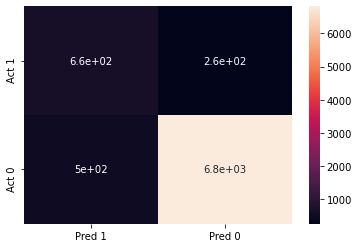

In [37]:
cm_RFminmax = confusion_matrix(y_test_dummy, y_pred_dummy_RFminmax, labels=[1, 0]) 
df_cm_RFminmax = pd.DataFrame(cm_RFminmax, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_RFminmax, annot=True)

In [38]:
roc_auc_score(y_test_dummy, y_pred_dummy_RFminmax)

0.8244396846549366

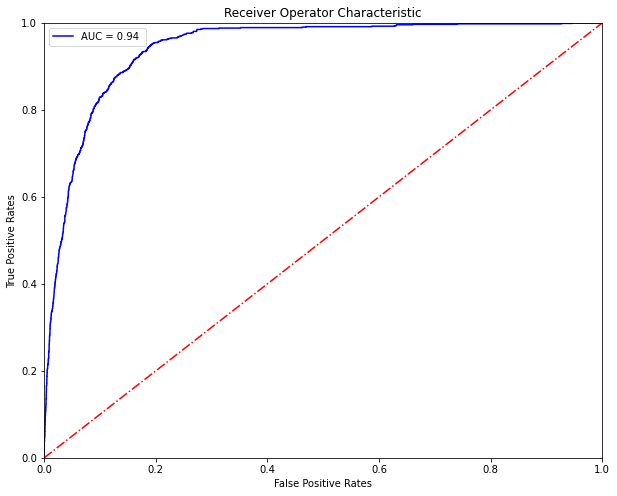

In [28]:
probs = model_dummyRF2.predict_proba(X_test_minmaxscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [66]:
model_dummyRF2.best_params_

{'max_depth': 8,
 'max_features': 0.5,
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 400}

In [67]:
model_dummyRF2.best_score_

0.9140818850744569

In [32]:
scaler_standard = StandardScaler()

X_train_standardscaled = scaler_standard.fit_transform(X_train_dummy)

X_test_standardscaled = scaler_standard.fit_transform(X_test_dummy)

model_dummyRF3 = RandomForestClassifier()

params_dummyRF = {
    "n_estimators" : [100, 400, 700, 1000],  
    "max_depth" : [None, 2, 4, 6, 8, 10],
    "min_samples_split" : [2,6,10],
    "min_samples_leaf" : [1,3,5],
    "max_features" : ["auto", 0.25, 0.5, 0.75, 1]
}

model_dummyRF3 = GridSearchCV(model_dummyRF3, params_dummyRF, cv=3, n_jobs=-1, verbose=1)

model_dummyRF3.fit(X_train_standardscaled, y_train_dummy)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 42.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 56.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 69.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 87.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 113.3min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 114.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10],
                         'max_features': ['auto', 0.25, 0.5, 0.75, 1],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [100, 400, 700, 1000]},
             verbose=1)

In [33]:
y_pred_dummy_RFstandard = model_dummyRF3.predict(X_test_standardscaled)

print(classification_report(y_test_dummy, y_pred_dummy_RFstandard))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.66      0.52      0.58       928

    accuracy                           0.92      8238
   macro avg       0.80      0.74      0.77      8238
weighted avg       0.91      0.92      0.91      8238



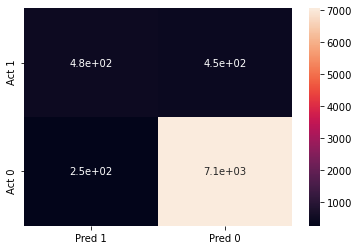

In [34]:
cm_RFstandard = confusion_matrix(y_test_dummy, y_pred_dummy_RFstandard, labels=[1, 0]) 
df_cm_RFstandard = pd.DataFrame(cm_RFstandard, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_RFstandard, annot=True)

In [35]:
roc_auc_score(y_test_dummy, y_pred_dummy_RFstandard)

0.7428720104721921

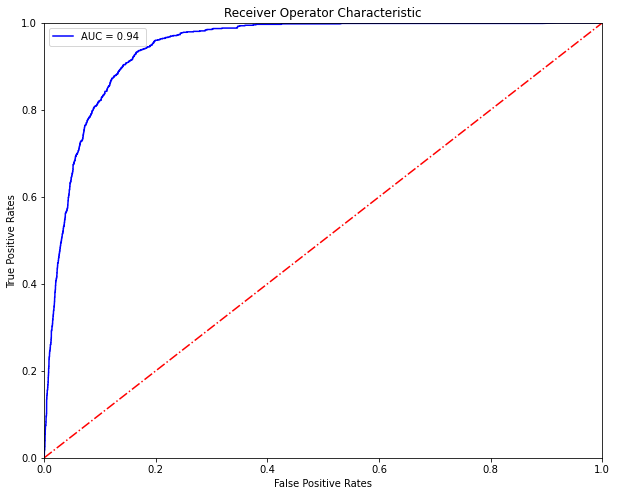

In [36]:
probs = model_dummyRF3.predict_proba(X_test_standardscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [68]:
model_dummyRF3.best_params_

{'max_depth': 8,
 'max_features': 0.75,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 700}

In [69]:
model_dummyRF3.best_score_

0.9139301354007188

## SVM (Support Vector Machine) Classifier

In [9]:
scaler_robust = RobustScaler()

X_train_robustscaled = scaler_robust.fit_transform(X_train_dummy)

X_test_robustscaled = scaler_robust.fit_transform(X_test_dummy)

model_dummySVC = SVC()

params_dummySVC = {
    "C" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "gamma" : np.logspace(-4, 4, 7),    
    "class_weight" : [None, "balanced"]
}

model_dummySVC = GridSearchCV(model_dummySVC, params_dummySVC, cv=3, n_jobs=-1, verbose=1)

model_dummySVC.fit(X_train_robustscaled, y_train_dummy)

Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 54.2min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'class_weight': [None, 'balanced'],
                         'gamma': array([1.00000000e-04, 2.15443469e-03, 4.64158883e-02, 1.00000000e+00,
       2.15443469e+01, 4.64158883e+02, 1.00000000e+04])},
             verbose=1)

In [10]:
y_pred_dummy_SVCrobust = model_dummySVC.predict(X_test_robustscaled)

print(classification_report(y_test_dummy, y_pred_dummy_SVCrobust))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.69      0.46      0.55       928

    accuracy                           0.92      8238
   macro avg       0.81      0.72      0.75      8238
weighted avg       0.91      0.92      0.91      8238



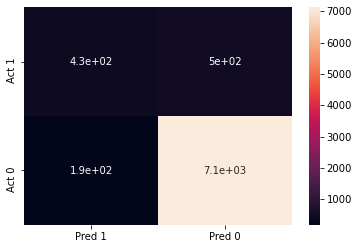

In [11]:
cm_SVCrobust = confusion_matrix(y_test_dummy, y_pred_dummy_SVCrobust, labels=[1, 0]) 
df_cm_SVCrobust = pd.DataFrame(cm_SVCrobust, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_SVCrobust, annot=True)

In [12]:
roc_auc_score(y_test_dummy, y_pred_dummy_SVCrobust)

0.7181463453464786

In [16]:
model_dummySVC.best_params_

{'C': 0.9, 'class_weight': None, 'gamma': 1.0}

In [17]:
model_dummySVC.best_score_

0.9111077047564536

In [38]:
scaler_robust = RobustScaler()

X_train_robustscaled = scaler_robust.fit_transform(X_train_dummy)

X_test_robustscaled = scaler_robust.fit_transform(X_test_dummy)

model_dummySVC_auc = SVC(probability = True, C = 0.9, class_weight = None, gamma = 1.0)

model_dummySVC_auc.fit(X_train_robustscaled, y_train_dummy)

SVC(C=0.9, gamma=1.0, probability=True)

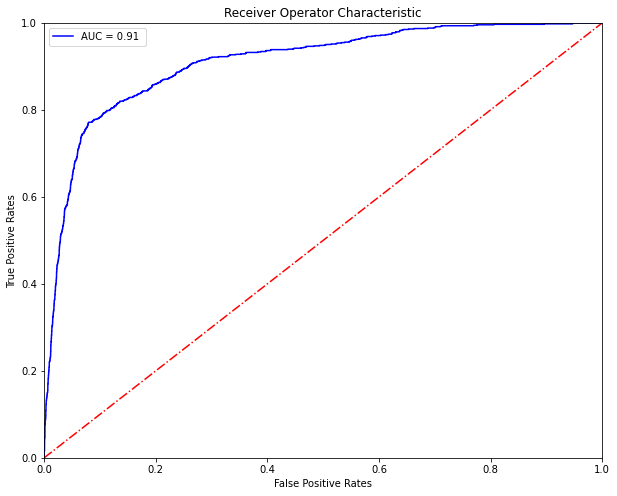

In [39]:
probs = model_dummySVC_auc.predict_proba(X_test_robustscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [14]:
scaler_minmax = MinMaxScaler()

X_train_minmaxscaled = scaler_minmax.fit_transform(X_train_dummy)

X_test_minmaxscaled = scaler_minmax.fit_transform(X_test_dummy)

model_dummySVC2 = SVC()

params_dummySVC = {
    "C" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "gamma" : np.logspace(-4, 4, 7),    
    "class_weight" : [None, "balanced"]
}

model_dummySVC2 = GridSearchCV(model_dummySVC2, params_dummySVC, cv=3, n_jobs=-1, verbose=1)

model_dummySVC2.fit(X_train_minmaxscaled, y_train_dummy)

Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 27.3min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'class_weight': [None, 'balanced'],
                         'gamma': array([1.00000000e-04, 2.15443469e-03, 4.64158883e-02, 1.00000000e+00,
       2.15443469e+01, 4.64158883e+02, 1.00000000e+04])},
             verbose=1)

In [15]:
y_pred_dummy_SVCminmax = model_dummySVC2.predict(X_test_minmaxscaled)

print(classification_report(y_test_dummy, y_pred_dummy_SVCminmax))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7310
           1       0.59      0.64      0.62       928

    accuracy                           0.91      8238
   macro avg       0.77      0.79      0.78      8238
weighted avg       0.91      0.91      0.91      8238



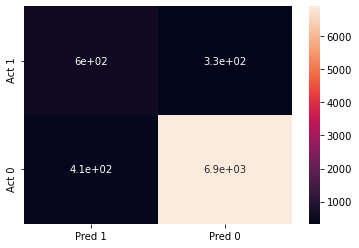

In [18]:
cm_SVCminmax = confusion_matrix(y_test_dummy, y_pred_dummy_SVCminmax, labels=[1, 0]) 
df_cm_SVCminmax = pd.DataFrame(cm_SVCminmax, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_SVCminmax, annot=True)

In [20]:
roc_auc_score(y_test_dummy, y_pred_dummy_SVCminmax)

0.7942912991178829

In [22]:
model_dummySVC2.best_params_

{'C': 0.9, 'class_weight': None, 'gamma': 464.1588833612773}

In [23]:
model_dummySVC2.best_score_

0.9119271308898077

In [40]:
scaler_minmax = MinMaxScaler()

X_train_minmaxscaled = scaler_minmax.fit_transform(X_train_dummy)

X_test_minmaxscaled = scaler_minmax.fit_transform(X_test_dummy)

model_dummySVC_auc2 = SVC(probability = True, C = 0.9, class_weight = None, gamma = 464.1588833612773)

model_dummySVC_auc2.fit(X_train_minmaxscaled, y_train_dummy)

SVC(C=0.9, gamma=464.1588833612773, probability=True)

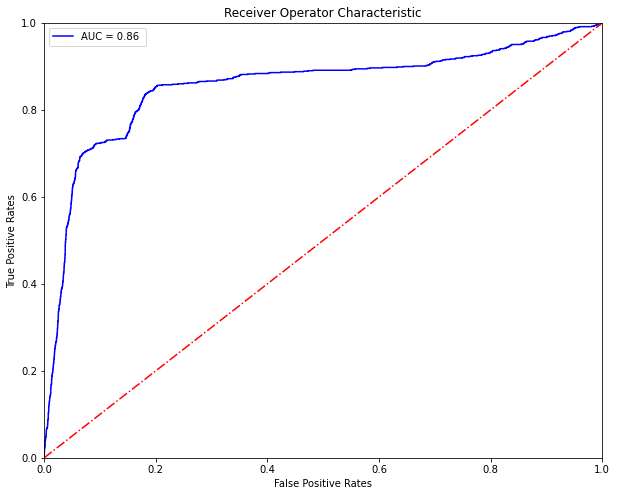

In [41]:
probs = model_dummySVC_auc2.predict_proba(X_test_minmaxscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [24]:
scaler_standard = StandardScaler()

X_train_standardscaled = scaler_standard.fit_transform(X_train_dummy)

X_test_standardscaled = scaler_standard.fit_transform(X_test_dummy)

model_dummySVC3 = SVC()

params_dummySVC = {
    "C" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "gamma" : np.logspace(-4, 4, 7),    
    "class_weight" : [None, "balanced"]
}

model_dummySVC3 = GridSearchCV(model_dummySVC3, params_dummySVC, cv=3, n_jobs=-1, verbose=1)

model_dummySVC3.fit(X_train_standardscaled, y_train_dummy)

Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 57.1min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'class_weight': [None, 'balanced'],
                         'gamma': array([1.00000000e-04, 2.15443469e-03, 4.64158883e-02, 1.00000000e+00,
       2.15443469e+01, 4.64158883e+02, 1.00000000e+04])},
             verbose=1)

In [25]:
y_pred_dummy_SVCstandard = model_dummySVC3.predict(X_test_standardscaled)

print(classification_report(y_test_dummy, y_pred_dummy_SVCstandard))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.69      0.47      0.56       928

    accuracy                           0.92      8238
   macro avg       0.81      0.72      0.76      8238
weighted avg       0.91      0.92      0.91      8238



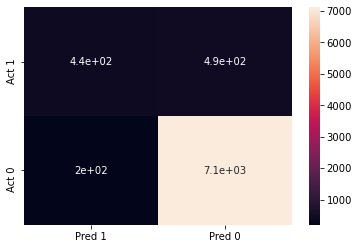

In [26]:
cm_SVCstandard = confusion_matrix(y_test_dummy, y_pred_dummy_SVCstandard, labels=[1, 0]) 
df_cm_SVCstandard = pd.DataFrame(cm_SVCstandard, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_SVCstandard, annot=True)

In [27]:
roc_auc_score(y_test_dummy, y_pred_dummy_SVCstandard)

0.7230554802113308

In [29]:
model_dummySVC3.best_params_

{'C': 0.9, 'class_weight': None, 'gamma': 1.0}

In [30]:
model_dummySVC3.best_score_

0.9128983177493161

In [42]:
scaler_standard = StandardScaler()

X_train_standardscaled = scaler_standard.fit_transform(X_train_dummy)

X_test_standardscaled = scaler_standard.fit_transform(X_test_dummy)

model_dummySVC_auc3 = SVC(probability = True, C = 0.9, class_weight = None, gamma = 1.0)

model_dummySVC_auc3.fit(X_train_standardscaled, y_train_dummy)

SVC(C=0.9, gamma=1.0, probability=True)

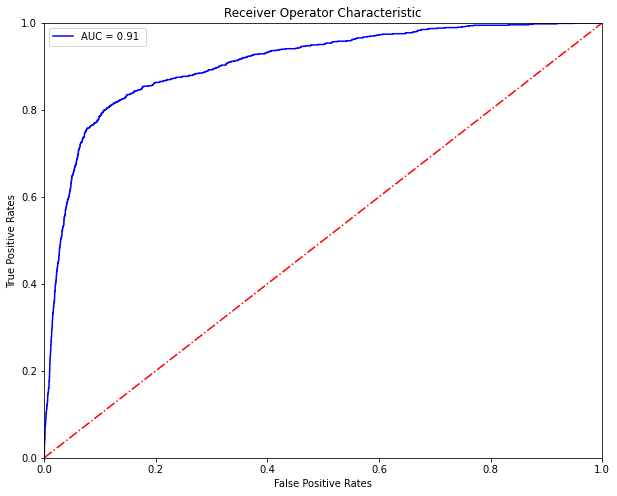

In [43]:
probs = model_dummySVC_auc3.predict_proba(X_test_standardscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

## XGBoost (Extreme Gradient Boosting) Classifier

In [50]:
scaler_robust = RobustScaler()

X_train_robustscaled = scaler_robust.fit_transform(X_train_dummy)

X_test_robustscaled = scaler_robust.fit_transform(X_test_dummy)

model_dummyXGB = XGBClassifier()

params_dummyXGB = {
    "max_depth" : [3, 5, 7, 10],
    "learning_rate" : [0.1, 0.3, 0.5, 0.7, 1],    
    "n_estimators" : [100, 300, 500, 700, 1000],
    "gamma" : [0, 0.3, 0.5, 0.7, 1],
}

model_dummyXGB = GridSearchCV(model_dummyXGB, params_dummyXGB, cv=3, n_jobs=-1, verbose=1)

model_dummyXGB.fit(X_train_robustscaled, y_train_dummy)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 67.2min finished


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'gamma': [0, 0.3, 0.5, 0.7, 1],
                         'learning_rate': [0.1, 0.3, 0.5, 0.7, 1],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 300, 500, 700, 1000]},
             verbose=1)

In [51]:
y_pred_dummy_XGBrobust = model_dummyXGB.predict(X_test_robustscaled)

print(classification_report(y_test_dummy, y_pred_dummy_XGBrobust))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7310
           1       0.71      0.53      0.61       928

    accuracy                           0.92      8238
   macro avg       0.82      0.75      0.78      8238
weighted avg       0.92      0.92      0.92      8238



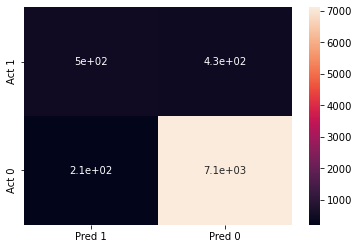

In [52]:
cm_XGBrobust = confusion_matrix(y_test_dummy, y_pred_dummy_XGBrobust, labels=[1, 0]) 
df_cm_XGBrobust = pd.DataFrame(cm_XGBrobust, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_XGBrobust, annot=True)

In [53]:
roc_auc_score(y_test_dummy, y_pred_dummy_XGBrobust)

0.753151092032643

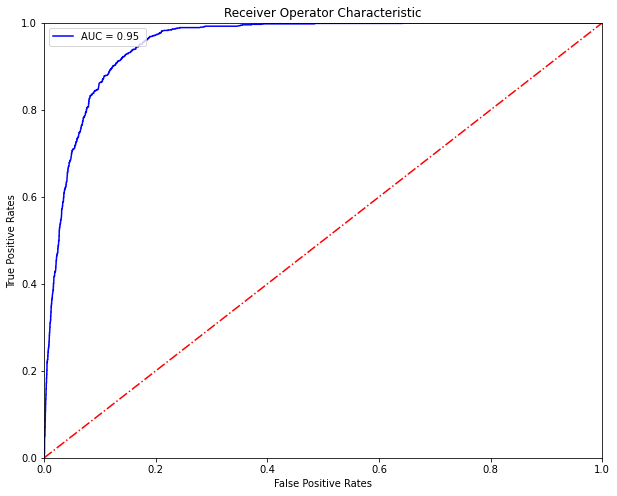

In [54]:
probs = model_dummyXGB.predict_proba(X_test_robustscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [55]:
model_dummyXGB.best_params_

{'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

In [56]:
model_dummyXGB.best_score_

0.9154779212845595

In [69]:
scaler_minmax = MinMaxScaler()

X_train_minmaxscaled = scaler_minmax.fit_transform(X_train_dummy)

X_test_minmaxscaled = scaler_minmax.fit_transform(X_test_dummy)

model_dummyXGB2 = XGBClassifier()

params_dummyXGB = {
    "max_depth" : [3, 5, 7, 10],
    "learning_rate" : [0.1, 0.3, 0.5, 0.7, 1],    
    "n_estimators" : [100, 300, 500, 700, 1000],
    "gamma" : [0, 0.3, 0.5, 0.7, 1],
}

model_dummyXGB2 = GridSearchCV(model_dummyXGB2, params_dummyXGB, cv=3, n_jobs=-1, verbose=1)

model_dummyXGB2.fit(X_train_minmaxscaled, y_train_dummy)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 53.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 62.6min finished


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'gamma': [0, 0.3, 0.5, 0.7, 1],
                         'learning_rate': [0.1, 0.3, 0.5, 0.7, 1],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 300, 500, 700, 1000]},
             verbose=1)

In [70]:
y_pred_dummy_XGBminmax = model_dummyXGB2.predict(X_test_minmaxscaled)

print(classification_report(y_test_dummy, y_pred_dummy_XGBminmax))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7310
           1       0.57      0.62      0.59       928

    accuracy                           0.90      8238
   macro avg       0.76      0.78      0.77      8238
weighted avg       0.91      0.90      0.91      8238



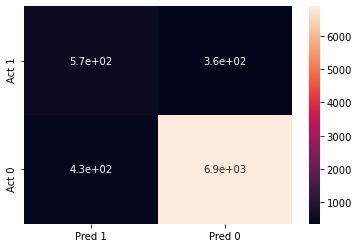

In [71]:
cm_XGBminmax = confusion_matrix(y_test_dummy, y_pred_dummy_XGBminmax, labels=[1, 0]) 
df_cm_XGBminmax = pd.DataFrame(cm_XGBminmax, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_XGBminmax, annot=True)

In [72]:
roc_auc_score(y_test_dummy, y_pred_dummy_XGBminmax)

0.7789830888249446

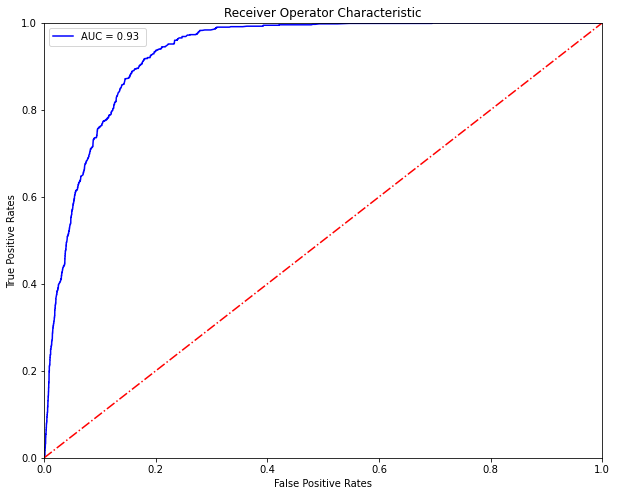

In [73]:
probs = model_dummyXGB2.predict_proba(X_test_minmaxscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [74]:
model_dummyXGB2.best_params_

{'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

In [75]:
model_dummyXGB2.best_score_

0.9154172214150642

In [44]:
scaler_standard = StandardScaler()

X_train_standardscaled = scaler_standard.fit_transform(X_train_dummy)

X_test_standardscaled = scaler_standard.fit_transform(X_test_dummy)

model_dummyXGB3 = XGBClassifier()

params_dummyXGB = {
    "max_depth" : [3, 5, 7, 10],
    "learning_rate" : [0.1, 0.3, 0.5, 0.7, 1],    
    "n_estimators" : [100, 300, 500, 700, 1000],
    "gamma" : [0, 0.3, 0.5, 0.7, 1],
}

model_dummyXGB3 = GridSearchCV(model_dummyXGB3, params_dummyXGB, cv=3, n_jobs=-1, verbose=1)

model_dummyXGB3.fit(X_train_standardscaled, y_train_dummy)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 64.0min finished


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'gamma': [0, 0.3, 0.5, 0.7, 1],
                         'learning_rate': [0.1, 0.3, 0.5, 0.7, 1],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 300, 500, 700, 1000]},
             verbose=1)

In [45]:
y_pred_dummy_XGBstandard = model_dummyXGB3.predict(X_test_standardscaled)

print(classification_report(y_test_dummy, y_pred_dummy_XGBstandard))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7310
           1       0.64      0.52      0.58       928

    accuracy                           0.91      8238
   macro avg       0.79      0.74      0.76      8238
weighted avg       0.91      0.91      0.91      8238



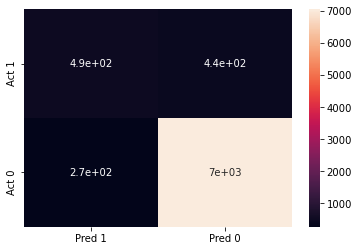

In [46]:
cm_XGBstandard = confusion_matrix(y_test_dummy, y_pred_dummy_XGBstandard, labels=[1, 0]) 
df_cm_XGBstandard = pd.DataFrame(cm_XGBstandard, 
                 columns=['Pred 1', 'Pred 0'],
                 index = ['Act 1', 'Act 0'])
sns.heatmap(df_cm_XGBstandard, annot=True)

In [47]:
roc_auc_score(y_test_dummy, y_pred_dummy_XGBstandard)

0.7439243891221283

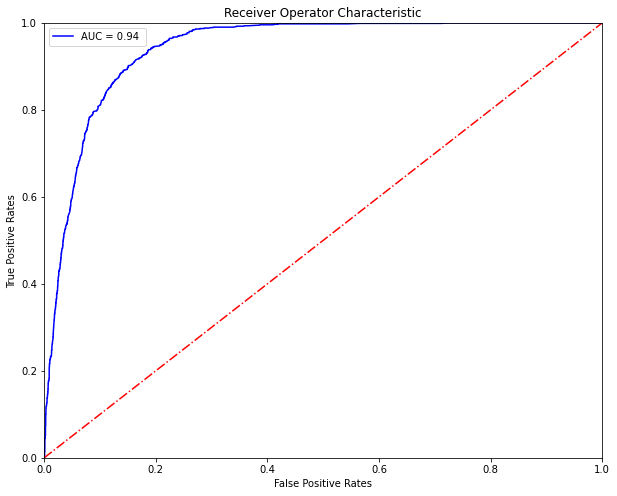

In [48]:
probs = model_dummyXGB3.predict_proba(X_test_standardscaled)

preds = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test_dummy, preds)
sc = round(auc(fpr,tpr),2)

plt.figure(figsize=(10,8))
plt.title("Receiver Operator Characteristic")
plt.plot(fpr, tpr, 'b', label=f'AUC = {sc} ')

plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [49]:
model_dummyXGB3.best_params_

{'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

In [50]:
model_dummyXGB3.best_score_

0.9154475713498119